In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
from dataclasses import dataclass, field
from statistics import geometric_mean
from typing import DefaultDict
from collections import defaultdict


@dataclass
class TraceStat:
    insn: int
    cycles: int
    misp: int
    mpki: float = field(init=False)
    ipc: float = field(init=False)

    def __post_init__(self):
        self.mpki = self.misp * 1e3 / self.insn
        self.ipc = self.insn / self.cycles


@dataclass
class TracelistStats:
    stats: dict[str, TraceStat] = field(default_factory=dict)

    def add_stat(self, trace_name: str, stat: TraceStat):
        self.stats[trace_name] = stat

    @property
    def mpki(self) -> float:
        return geometric_mean(map(lambda x: x.mpki, self.stats.values()))

    @property
    def ipc(self) -> float:
        return geometric_mean(map(lambda x: x.ipc, self.stats.values()))

In [3]:
pred = ["bimodal", "freq", "prob"]
DIR = Path.cwd() / "results"
stat_dirs = [DIR / p for p in pred]
stats: DefaultDict[str, TracelistStats] = defaultdict(TracelistStats)
for stat_dir in stat_dirs:
    for stat_file in stat_dir.iterdir():
        assert stat_file.suffix == ".json"
        with open(stat_file) as f:
            data = json.load(f)[0]["sim"]["cores"][0]
        stat = TraceStat(
            insn=data["instructions"],
            cycles=data["cycles"],
            misp=sum(data["mispredict"].values()),
        )
        del data
        stats[stat_dir.stem].add_stat(stat_file.stem, stat)
mpkis = dict(zip(stats, map(lambda s: s.mpki, stats.values())))
ipcs = dict(zip(stats, map(lambda s: s.ipc, stats.values())))

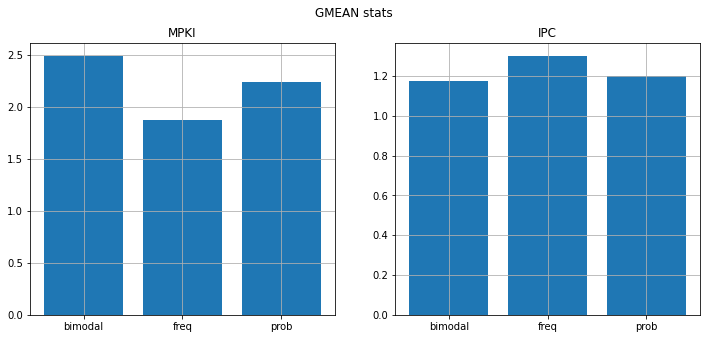

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
fig.suptitle("GMEAN stats")
ax1.set_title("MPKI")
ax1.bar(mpkis.keys(), mpkis.values())
ax1.grid()

ax2.set_title("IPC")
ax2.bar(ipcs.keys(), ipcs.values())
ax2.grid()